<a href="https://colab.research.google.com/github/sanntana21/TFG/blob/main/aggregated_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCIONES AGREGADAS**

In [87]:
print("v.1.2")

v.0.2


In [88]:
from tensorflow.keras import layers
import pandas as pd
import statsmodels
from statistics import mean, median
import numpy as np
import pickle
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random as random
import plotly.express as px
import tensorflow as tf
import gzip

def set_output_precision(decimals):
    """
    format the output of the all the data structures
    with an specific number of decimals
    """
    np.set_printoptions(precision=decimals)
    into='{'+':.{}f'.format(decimals)+'}'
    pd.options.display.float_format = into.format
    pass

def plot_ts(df,dfx="Minute",dfy="METS",_title="DF minute x Mets"):
    if not isinstance(df,pd.DataFrame):
        df = pd.DataFrame({'METS': df, 'Minute': range(len(df))})

    plt.figure()
    fig = px.line(df, x = dfx, y = dfy , title = _title)
    fig.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="2y",step="year",stepmode="backward"),
                dict(count=3,label="3y",step="year",stepmode="backward"),
                dict(step="all")
            ])
        )

    )
    fig.show()

def plot_predictions_vs_real(predictions, reals):
    df = pd.DataFrame()
    number_of_points = len(predictions)
    df["time"] = range(0,number_of_points)
    df["participant"] = "prediction"
    df["value"] = predictions
    for i in range(0,number_of_points):
        df.loc[number_of_points+i] = [i,"real",reals[i]]

    plt.figure(1)

    fig = px.line(df, x = "time", y = "value" , title = "Predictions vs Reals Time Series" , color = "participant",template='seaborn')
    fig.update_layout(
    plot_bgcolor='white'
    )

    fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )

    fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )

    fig2 = fig
    fig2.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="2y",step="year",stepmode="backward"),
                dict(count=3,label="3y",step="year",stepmode="backward"),
                dict(step="all")
            ])
        )

    )


    return fig,fig2

def plot_dispersion_in_predictions(predictions, reals,max_=None,min_=None):
    df = pd.DataFrame()
    number_of_points = len(predictions)
    df["real"] = reals
    df["prediction"] = predictions

    if not max_:
        maximun = max(df["real"].max(),df["prediction"].max())
    if not min_:
        minimun = min(df["real"].min(),df["prediction"].min())

    range_to_plot = [minimun-10,maximun+10]

    plt.figure(1)
    fig = px.scatter(df, x = "real", y = "prediction" , title = "Actual vs Predicted Values",trendline="ols",range_x=range_to_plot,range_y=range_to_plot,trendline_color_override='black',template='seaborn')
    fig.update_layout(
    plot_bgcolor='white'
    )
    fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    parameters = px.get_trendline_results(fig)["px_fit_results"].get(0).params
    return fig,parameters


In [89]:
INDEXS = [
        #SPLIT 0
        {"train":[{"start":{"day":2,"hour":0,"minute":0},
                     "end":{"day":21,"hour":22,"minute":0}}
                    ],
           "validation":[{"start":{"day":23,"hour":0,"minute":0},
                     "end":{"day":24,"hour":22,"minute":0}}
                    ],
           "test":[{"start":{"day":26,"hour":0,"minute":0},
                     "end":{"day":27,"hour":22,"minute":0}}
                    ]
         },
          #SPLIT 1
        {
            "train":[{"start":{"day":5,"hour":0,"minute":0},
                     "end":{"day":24,"hour":22,"minute":0}}
                    ],
           "validation":[{"start":{"day":26,"hour":0,"minute":0},
                     "end":{"day":27,"hour":22,"minute":0}}
                    ],
           "test":[{"start":{"day":2,"hour":0,"minute":0},
                     "end":{"day":3,"hour":22,"minute":0}},
                    ]
        },
        # SPLIT 2
        {
            "train":[{"start":{"day":7,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":2,"hour":0,"minute":0},
                        "end":{"day":3,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":5,"hour":0,"minute":0},
                  "end":{"day":6,"hour":22,"minute":0}},
                 ]
         },
        #SPLIT 3
        {
            "train":[{"start":{"day":10,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":3,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":5,"hour":0,"minute":0},
                        "end":{"day":6,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":8,"hour":0,"minute":0},
                  "end":{"day":9,"hour":22,"minute":0}},
                 ]
        },
        #SPLIT 4
        {
            "train":[{"start":{"day":14,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":6,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":8,"hour":0,"minute":0},
                        "end":{"day":9,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":11,"hour":0,"minute":0},
                  "end":{"day":12,"hour":22,"minute":0}},
                 ]
        },
        #SPLIT 5
        {
            "train":[{"start":{"day":17,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":9,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":11,"hour":0,"minute":0},
                        "end":{"day":12,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":14,"hour":0,"minute":0},
                  "end":{"day":15,"hour":22,"minute":0}},
                 ]
        },
        #SPLIT 6
        {
            "train":[{"start":{"day":20,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":13,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":14,"hour":0,"minute":0},
                        "end":{"day":15,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":17,"hour":0,"minute":0},
                  "end":{"day":18,"hour":22,"minute":0}},
                 ]
        },
        # SPLIT 7
            {
            "train":[{"start":{"day":23,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":15,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":17,"hour":0,"minute":0},
                        "end":{"day":18,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":20,"hour":0,"minute":0},
                  "end":{"day":21,"hour":22,"minute":0}},
                 ]
        },
        # SPLIT 8
            {
            "train":[{"start":{"day":26,"hour":0,"minute":0},
                   "end":{"day":28,"hour":22,"minute":0}},
                     {"start":{"day":2,"hour":0,"minute":0},
                    "end":{"day":18,"hour":22,"minute":0}}
                  ],
            "validation":[{"start":{"day":20,"hour":0,"minute":0},
                        "end":{"daY":21,"hour":22,"minute":0}}
                       ],
            "test":[{"start":{"day":23,"hour":0,"minute":0},
                  "end":{"day":24,"hour":22,"minute":0}},
                 ]
        },

          ]

In [90]:
READ_LOCAL_DATA = True
COMPUTED_OPTION = 1
SAVE_RESULTS = True
LOW_DATA = True
SPLIT_INTO_TWO_DAYS = False
np.random.seed(42)
MULTI_STEP_FORECAST = False
tf.random.set_seed(42)
SPLIT = 2

In [91]:
if READ_LOCAL_DATA:
  PATH = "Resources/Agregado/"
else:
    #  We start by getting access to the drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = "/content/drive/MyDrive/TFG/Resources/Agregado/"


if LOW_DATA:
    PATH += "LowData/"


In [92]:
import gzip
documents = ['minuteY','hourY','dayY']
# with open(PATH+"minuteX"+".pkl", 'rb') as file:
#     dataX = np.array(pickle.load(file),np.float32)
file = PATH+"minuteX.pkl.gz"
dataX = np.array(pickle.load(gzip.open(file, 'rb')),np.float32)

file = PATH+documents[COMPUTED_OPTION]+".pkl.gz"
dataY = np.array(pickle.load(gzip.open(file, 'rb')),np.float32)

dataX = np.sum(dataX,axis=0,keepdims=True)
dataY = np.sum(dataY,axis=0,keepdims=True)

In [93]:
if MULTI_STEP_FORECAST:
    PREDICTED_HORIZON = 1
    if COMPUTED_OPTION == 0:
        dataX_nuevo = dataX
        JUMP = 1
    elif COMPUTED_OPTION == 1:
        JUMP = 60
        dataX_nuevo = np.ones(shape=(dataX.shape[0],24))
        for i in range(0,dataX.shape[0]):
            for j in range(0,24):
                dataX_nuevo[i,j] = np.sum(dataX[i,60*j:60*(j+1)])
    else:
        JUMP = 1440
        dataX_nuevo = np.ones(shape=(dataX.shape[0],1))
        for i in range(0,dataX.shape[0]):
            dataX_nuevo[i,:] = np.sum(dataX[i,:])

In [94]:
#We split a test set for testing
# train_test_split(dataX, dataY, test_size=TEST_SIZE)

def calculate_index(time):
  minute_index = time["day"] * 1440 + time["hour"]*60 + time["minute"]
  return int(minute_index)

def get_split(dataX,dataY,index):
  start = calculate_index(index[0]["start"])
  end = calculate_index(index[0]["end"])
  X_split = dataX[:,start:end,:]
  y_split = dataY[:,start:end,:]
  if len(index) > 1:
    for i in range(1,len(index)):
      start = calculate_index(index[i]["start"])
      end = calculate_index(index[i]["end"])
      X_split = np.concatenate((X_split,dataX[:,start:end,:]),axis=1)
      y_split = np.concatenate((y_split,dataY[:,start:end,:]),axis=1)
  return X_split,y_split

def train_test_validation_split(dataX,dataY,indexs):
  X_train,y_train = get_split(dataX,dataY,indexs["train"])
  X_validation,y_validation = get_split(dataX,dataY,indexs["validation"])
  X_test,y_test = get_split(dataX,dataY,indexs["test"])
  return X_train,y_train,X_validation,y_validation,X_test,y_test


X_train,y_train,X_validation,y_validation,X_test,y_test = train_test_validation_split(dataX,dataY,INDEXS[SPLIT])
print("Examples for training\n","X:",X_train.shape,"y:",y_train.shape)
print("Examples for validation\n","X:",X_validation.shape,"y:",y_validation.shape)
print("Examples for test\n","X:",X_test.shape,"y:",y_test.shape)


Examples for training
 X: (1, 30120, 1440) y: (1, 30120, 2)
Examples for validation
 X: (1, 2760, 1440) y: (1, 2760, 2)
Examples for test
 X: (1, 2760, 1440) y: (1, 2760, 2)


In [95]:
#Quitamos en este caso la primera dimension
X_train,y_train,X_validation,y_validation,X_test,y_test = [
  np.squeeze(i) for i in [X_train,y_train,X_validation,y_validation,X_test,y_test]
]

print("Examples for training\n","X:",X_train.shape,"y:",y_train.shape)
print("Examples for validation\n","X:",X_validation.shape,"y:",y_validation.shape)
print("Examples for test\n","X:",X_test.shape,"y:",y_test.shape)

Examples for training
 X: (30120, 1440) y: (30120, 2)
Examples for validation
 X: (2760, 1440) y: (2760, 2)
Examples for test
 X: (2760, 1440) y: (2760, 2)


#**DEFINICION DEL MODELO**

In [96]:
tf.random.set_seed(42)
# Setup dataset hyperparameters
HORIZON = y_test.shape[1]
WINDOW_SIZE = X_test.shape[1]

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_LSTM = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_LSTM.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1440)]            0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 1440)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               803328    
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 803,586
Trainable params: 803,586
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Compile model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="auto"
)
model_LSTM.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
             metrics=["mae"])


In [98]:
# # Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
hist = model_LSTM.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=256,
            validation_data=(X_validation, y_validation),
               callbacks=[early_stopping])

Epoch 1/100
118/118 [==============================] - 2s 11ms/step - loss: 400.1243 - mae: 400.1243 - val_loss: 158.1015 - val_mae: 158.1015
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 150.3057 - mae: 150.3057 - val_loss: 150.0272 - val_mae: 150.0272
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 132.5704 - mae: 132.5704 - val_loss: 150.4303 - val_mae: 150.4303
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 120.7133 - mae: 120.7133 - val_loss: 138.8375 - val_mae: 138.8375
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 115.0890 - mae: 115.0890 - val_loss: 135.8249 - val_mae: 135.8249
Epoch 6/100
118/118 [==============================] - 1s 12ms/step - loss: 112.4544 - mae: 112.4544 - val_loss: 126.8419 - val_mae: 126.8419
Epoch 7/100
118/118 [==============================] - 1s 12ms/step - loss: 109.4221 - mae: 109.4221 - val_loss: 122.3240 - val_mae: 122.3240
Epoch 

In [99]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data,verbose=2)
  return tf.squeeze(forecast) # return 1D array of predictions

predictions = make_preds(model_LSTM, X_test)

87/87 - 0s - 219ms/epoch - 3ms/step


In [100]:
print("Resultados comparando directamente las salidas")
print(y_test.shape)
print(predictions.shape)
POINT_TO_POINT_MSE = mean_squared_error(y_test,predictions)
POINT_TO_POINT_MAE = mean_absolute_error(y_test,predictions)
print('\033[1m' + "MSE: " + str(mean_squared_error(y_test,predictions)) + '\033[0m')
print('\033[1m' + "MAE: " + str(mean_absolute_error(y_test,predictions)) + '\033[0m')
print(np.mean(y_test))

Resultados comparando directamente las salidas
(2760, 2)
(2760, 2)
MSE: 19504.195
MAE: 102.231834
2342.0737


In [101]:
SPLIT_INTO_TWO_DAYS = True

print("Resultados poblacionales cada dos horas")
POBLATIONAL_MAE = mean_absolute_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))
POBLATIONAL_MSE = mean_squared_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))
BEST_MEDIUM_WORST_MAE = [0,0,0]
BEST_MEDIUM_WORST_FIG = [0,0,0]
BEST_MEDIUM_WORST_FIG_DISPERSION = [0,0,0]
BEST_MEDIUM_WORST_VALUE_DISPERSION = [0,0,0]
print('\033[1m' + "MSE: " + str(mean_squared_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))) + '\033[0m')
print('\033[1m' + "MAE: " + str(mean_absolute_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))) + '\033[0m')
list_of_MAE = [  mean_absolute_error(predictions[i],y_test[i]) for i in range(0,len(y_test)) ]
list_of_values = sorted(list_of_MAE)
mean_value = mean(list_of_MAE)
closest_value = min(list_of_MAE, key=lambda x: abs(x - mean_value))
index_result = 0
# Crear un array de índices
indices = [list_of_MAE.index(list_of_values[-1]),
         list_of_MAE.index(closest_value) ,
        list_of_MAE.index(list_of_values[0])]
if COMPUTED_OPTION == 0:
    for i in indices:
      BEST_MEDIUM_WORST_MAE[index_result] = list_of_MAE[i]
      BEST_MEDIUM_WORST_FIG[index_result],_ = plot_predictions_vs_real(predictions[i],y_test[i])
      BEST_MEDIUM_WORST_FIG_DISPERSION[index_result],BEST_MEDIUM_WORST_VALUE_DISPERSION[index_result]= plot_dispersion_in_predictions(predictions[i],y_test[i])
      BEST_MEDIUM_WORST_FIG[index_result].show()
      index_result += 1
else:
    for i in indices:
        BEST_MEDIUM_WORST_MAE[index_result] = list_of_MAE[i]
        END = 24
        STARTED_MINUTE = 0
        previous = np.ones(shape=(24))
        for j in range(0,24):
            previous[j] = np.sum(X_test[i,:][60*j:60*(j+1)])
        predictions_to_plot = np.ones(shape=(END + HORIZON))
        predictions_to_plot[0:END] = previous[:]
        predictions_to_plot[END:] = predictions[i,:]
        y_test_to_plot = np.ones(shape=(END + HORIZON))
        y_test_to_plot[0:END] = previous[:]
        y_test_to_plot[END:] = y_test[i,:]
        BEST_MEDIUM_WORST_FIG[index_result],_  = plot_predictions_vs_real(predictions_to_plot,y_test_to_plot)
        BEST_MEDIUM_WORST_FIG_DISPERSION[index_result],BEST_MEDIUM_WORST_VALUE_DISPERSION[index_result]= plot_dispersion_in_predictions(predictions_to_plot,y_test_to_plot)
        BEST_MEDIUM_WORST_FIG[index_result].show()
        index_result += 1

if SPLIT_INTO_TWO_DAYS:
  index = 0
  period = X_test[::120,:]
  period_results = make_preds(model_LSTM,period)
  period_results_to_plot = np.array(period_results).reshape(HORIZON*23)
  y_test_to_plot = y_test[::120,:].reshape(HORIZON*23)
  TWO_DAYS_RESULTS_FIG,\
      TWO_DAYS_RESULTS_FIG_ZOOMED = plot_predictions_vs_real(predictions=period_results_to_plot,reals=y_test_to_plot)
  print('\033[1m' + "Predicted: " + str(np.sum(period_results_to_plot)) + '\033[0m')
  print('\033[1m' + "Reals: " + str(np.sum(y_test_to_plot)) + '\033[0m')
  TWO_DAYS_RESULTS_PREDICTED = np.sum(period_results_to_plot)
  TWO_DAYS_RESULTS_REAL = np.sum(y_test_to_plot)
  TWO_DAYS_RESULTS_DISPERSION_FIG,\
      TWO_DAYS_RESULTS_DISPERSION_VALUE= plot_dispersion_in_predictions(period_results_to_plot,y_test_to_plot)
  TWO_DAYS_RESULTS_FIG.show()
  TWO_DAYS_RESULTS_DISPERSION_FIG.show()

Resultados poblacionales cada dos horas
MSE: 63154.973
MAE: 188.1644


1/1 - 0s - 13ms/epoch - 13ms/step
Predicted: 105156.72
Reals: 107659.55


<Figure size 640x480 with 0 Axes>

In [102]:
# Transform the array into shape (23,) by summing pairs
predictions_transformed = []
test_transformed = []
for i in range(0, len(period_results_to_plot), HORIZON):
    group_sum = np.sum(period_results_to_plot[i:i + HORIZON])
    predictions_transformed.append(group_sum)
    group_sum = np.sum(y_test_to_plot[i:i+HORIZON])
    test_transformed.append(group_sum)

# Convert the transformed list into a numpy array
predictions_transformed = np.array(predictions_transformed)
test_transformed = np.array(test_transformed)
TRANSFORMED_PREDICITION_FIG,_  = plot_predictions_vs_real(predictions_transformed,test_transformed)
TRANSFORMED_PREDICITION_DISPERSION_FIG, TRANSFORMED_PREDICITION_DISPERSION_VALUE = plot_dispersion_in_predictions(predictions_transformed,test_transformed)

<Figure size 640x480 with 0 Axes>

In [103]:
import os
import json
SAVE_RESULTS = True
if SAVE_RESULTS:
    if READ_LOCAL_DATA:
        file_path = 'Resources/Resultados/Agregado/'
    else:
        file_path = "/content/drive/MyDrive/TFG/Resources/Resultados/Agregado/"
    if LOW_DATA:
        file_path += "LowData/"

    file_path += "Split"+str(SPLIT) + "/"

    if COMPUTED_OPTION == 0:
        file_path += "minute/"
    else:
        file_path += "hour/"

    info_results = dict(
            POINT_TO_POINT_MAE = POINT_TO_POINT_MAE,
            POINT_TO_POINT_MSE = POINT_TO_POINT_MSE,
            POBLATIONAL_MAE = POBLATIONAL_MAE,
            POBLATIONAL_MSE = POBLATIONAL_MSE,
            BEST = BEST_MEDIUM_WORST_MAE[2],
            BEST_OLS = BEST_MEDIUM_WORST_VALUE_DISPERSION[2],
            MEDIUM = BEST_MEDIUM_WORST_MAE[1],
            MEDIUM_OLS = BEST_MEDIUM_WORST_VALUE_DISPERSION[1],
            WORST = BEST_MEDIUM_WORST_MAE[0],
            WORST_OLS = BEST_MEDIUM_WORST_VALUE_DISPERSION[0],
            TWO_DAYS_RESULTS_REAL = TWO_DAYS_RESULTS_REAL,
            TWO_DAYS_RESULTS_PREDICTED = TWO_DAYS_RESULTS_PREDICTED,
            TWO_DAYS_OLS = TWO_DAYS_RESULTS_DISPERSION_VALUE,
            TRANSFORMED_PREDICITION_OLS = TRANSFORMED_PREDICITION_DISPERSION_VALUE,
            HIST = hist.history
        )
    isExist = os.path.exists(file_path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(file_path)
        print("Nuevo directorio:" + file_path)
    with open(file_path+"/info_resultados.txt", 'w') as f:
        json.dump(json.dumps(str(info_results),indent=4), f,ensure_ascii=False,indent=4)


    #Guardamos las imagenes restantes
    TWO_DAYS_RESULTS_DISPERSION_FIG.write_html(file_path+"/TWO_DAYS_OLS"+".html")
    BEST_MEDIUM_WORST_FIG[0].write_html(file_path+"/WORST_MAE"+".html")
    BEST_MEDIUM_WORST_FIG[1].write_html(file_path+"/AVERAGE_MAE"+".html")
    BEST_MEDIUM_WORST_FIG[2].write_html(file_path+"/BEST_MAE"+".html")
    BEST_MEDIUM_WORST_FIG_DISPERSION[0].write_html(file_path+"/WORST_MAE_OLS"+".html")
    BEST_MEDIUM_WORST_FIG_DISPERSION[1].write_html(file_path+"/AVERAGE_MAE_OLS"+".html")
    BEST_MEDIUM_WORST_FIG_DISPERSION[2].write_html(file_path+"/BEST_MAE_OLS"+".html")
    TWO_DAYS_RESULTS_DISPERSION_FIG.write_html(file_path+"/TWO_DAYS_FIG"+".html")
    TRANSFORMED_PREDICITION_FIG.write_html(file_path+"/TRANSFORMED_PREDICTION"+".html")
    TRANSFORMED_PREDICITION_DISPERSION_FIG.write_html(file_path+"/TRANSFORMED_PREDICTION_OLS"+".html"),
    TWO_DAYS_RESULTS_FIG_ZOOMED.write_html(file_path+"/TWO_DAYS_RESULTS_FIG"+".html")

Nuevo directorio:Resources/Resultados/Agregado/LowData/Split2/hour/


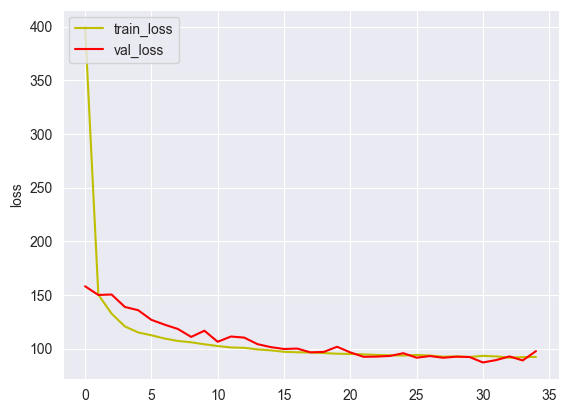

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history["loss"], "y", label = "train_loss")
loss_ax.plot(hist.history["val_loss"], "r", label = "val_loss")


loss_ax.set_ylabel("loss")

loss_ax.legend(loc = "upper left")

plt.savefig(file_path+"/curvas_aprendizaje")

In [105]:
if MULTI_STEP_FORECAST:
    day_before = np.array(X_test[0:1,:],dtype=np.float32)
    predicted_values_day_one = np.ones(shape=(WINDOW_SIZE,1),dtype=np.float32)
    for i in range(0,WINDOW_SIZE):
        prediction = float(make_preds(model_LSTM, day_before))
        day_before[:,0:-1] = day_before[:,1:]
        day_before[:,-1] = prediction
        predicted_values_day_one[i,0] = prediction

    SECOND_DAY = X_test.shape[1]
    day_before = np.array(X_test[SECOND_DAY:SECOND_DAY+1,:],dtype=np.float32)
    predicted_values_day_two = np.ones(shape=(WINDOW_SIZE,1),dtype=np.float32)
    for i in range(0,WINDOW_SIZE):
        prediction = float(make_preds(model_LSTM, day_before))
        day_before[:,0:-1] = day_before[:,1:]
        day_before[:,-1] = prediction
        predicted_values_day_two[i,0] = prediction
if MULTI_STEP_FORECAST:
    print("Predecidos : " + str(int(np.sum(predicted_values_day_one[:,0]))))
    print("Reales : " + str(int(np.sum(y_test[0:WINDOW_SIZE,0]))))
    if COMPUTED_OPTION < 2:
        plot_predictions_vs_real(predicted_values_day_one[:,0],y_test[0:WINDOW_SIZE,0])
if MULTI_STEP_FORECAST:
    print("Predecidos : " + str(int(np.sum(predicted_values_day_two[:,0]))))
    print("Reales : " + str(int(np.sum(y_test[SECOND_DAY:,0]))))
    if COMPUTED_OPTION < 2:
        plot_predictions_vs_real(predicted_values_day_two[:,0],y_test[SECOND_DAY:,0])